### N.B. This notebook relies on files that are local to this example and may need to be edited if file permissions are not working, for example.

## Calculate the bathymetric roughness term, h, in Jayne and St. Laurent (2001), based on choices of input bathymetry and model grid.   See README for more details.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from scipy.optimize import least_squares

### Read the bathymetry data

In [3]:
# There are a couple of options here.  We use GEBCO2023 in this example.
# GEBCO2019 
fn_GEBCO2019= "/home/users/cwilso01/projects/senemo/data/raw/bathymetry/GEBCO/GEBCO2019/GEBCO_2019.nc"  
ds_G2019 = xr.open_dataset(fn_GEBCO2019)  
# GEBCO2023
fn_GEBCO2023= "/home/users/cwilso01/projects/senemo/data/raw/bathymetry/GEBCO/GEBCO2023/GEBCO_2023_sub_ice_topo.nc"  
ds_G2023 = xr.open_dataset(fn_GEBCO2023) 

### Read the model grid

In [4]:
# domain_cfg_GS1p2_full.nc 
fn_domcfg_GS1p2_full= "/home/users/cwilso01/projects/senemo/data/raw/domain_cfg_files/domain_cfg_GS1p2_full.nc"  
ds_domcfg_GS1p2_full = xr.open_dataset(fn_domcfg_GS1p2_full)  


### Plot a variable on the NEMO model grid to familiarise us with it

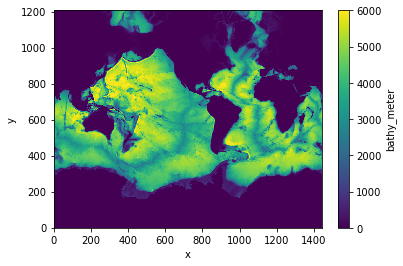

In [5]:
# Here, we plot the existing model bathymetry. 

ds_domcfg_GS1p2_full.bathy_meter.plot()

### Load the model bathymetry and the finer-scale bathymetry for the roughness calculation (GEBCO2023 here) into memory for faster calculations later

In [ ]:
bathy_model=ds_domcfg_GS1p2_full.bathy_meter.load()

bathy_GEBCO=ds_G2023.elevation.load()

# First, test the method on a single NEMO (i,j) gridcell....

### For each i,j cell of the NEMO grid, want to a) identify which ii,jj cells of the GEBCO grid are spanned and then b) fit the polynomial H= a+bx+cy+dxy for the hyperbolic paraboloid surface, and finally, c) calculate the anomaly h'=H-GEBCO and the RMS h' over the NEMO cell, which defines the roughness, h.  d) repeat for all the NEMO ocean cells.

a) glamt(t,y,x) and gphit(t,x,y) correspond to the lon, lat of the NEMO grid at T-points.  These are in \[-180,180], \[-90,90], which matches the ranges of the GEBCO bathymetry lon and lat.  However, based on the Arakawa C-grid, to define the lon0:lon1 and lat0:lat1 of the i,j cell (which has the T-point at its centre, where the bathymetry is defined) we can use glamu(i-1,j):glamu(i,j) and gphiv(i,j-1):gphiv(i,j).    See https://www.nemo-ocean.eu/doc/node19.html for a schematic.

In [6]:
# Define NEMO grids as shorthand variables: lon at u-pt, lat at v-pt.
Nglamu=ds_domcfg_GS1p2_full.glamu
Ngphiv=ds_domcfg_GS1p2_full.gphiv

### Plot a test patch of bathymetry in a single NEMO gridcell

In [ ]:
# This is the test for i=200, j=600 :
test=bathy_GEBCO.sel(lat=slice(Ngphiv[0,599,200],Ngphiv[0,600,200]),lon=slice(Nglamu[0,600,199],Nglamu[0,600,200]))

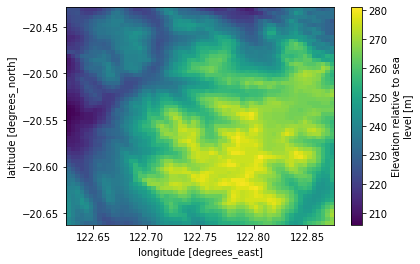

In [10]:
test.plot()

b) Fit the polynomial H=a+bx+cy+dxy to the above. Uses third method of nonlinear least-squares optimisation on https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html

In [ ]:
def hyperbolicparaboloid(theta,iimax,jjmax,ii,jj):
    # use ii, jj instead of distance on sphere, as Jayne and St. Laurent (2001)
    # is only a crude approximation and the grid is quite isotropic at these scales.
    # Assume that ii=0, jj=0 at the centre of the patch.
    # theta is an array of the constants a,b,c,d to be found.
    # This function corresponds to H=a+bx+cy+dxy in JSL2001.
    return theta[0]+theta[1]*(ii-iimax/2)+theta[2]*(jj-jjmax/2)+theta[3]*(ii-iimax/2)*(jj-jjmax/2)

iimax=test.shape[0] #the number of ii cells on the fine grid of the (GEBCO) bathymetry
jjmax=test.shape[1] #the number of jj cells

#build a grid
xs = np.linspace(0, iimax-1, iimax)
ys = np.linspace(0, jjmax-1, jjmax)
gridx, gridy = np.meshgrid(xs, ys)

#initial condition for parameters to be optimised
a = 0; b = 0; c=0; d=0 
theta0=[a,b,c,d]

# Minimise using least-squares the difference between the fitted function and the test data
def fun(theta):
    return (hyperbolicparaboloid(theta, iimax, jjmax, gridx, gridy).T - test.values).flatten()
    
fitpar = least_squares(fun, theta0)

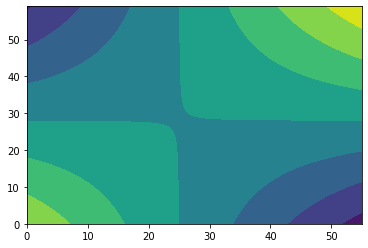

In [17]:
# Plot an arbitrary example of the hyperbolic paraboloid for this patch
plt.contourf(np.flipud(hyperbolicparaboloid([0,1,-3,-1], 56, 60, gridx, gridy)))

In [18]:
# List the optimised parameters
fitpar

 active_mask: array([0., 0., 0., 0.])
        cost: 243827.89231505914
         fun: array([-5.38703624, -1.57668813,  2.23365999, ..., 20.53090689,
       19.00143839, 17.47196988])
        grad: array([ 5.86267515e-06,  1.74622983e-10, -6.18456397e-10, -7.21774995e-09])
         jac: array([[  1.00000001, -28.        , -30.        , 840.        ],
       [  1.00000001, -28.        , -29.        , 812.        ],
       [  1.00000001, -28.        , -28.        , 784.        ],
       ...,
       [  1.        ,  27.        ,  27.        , 729.        ],
       [  1.        ,  27.        ,  28.        , 756.        ],
       [  1.        ,  27.        ,  29.        , 783.        ]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 10
        njev: 9
  optimality: 5.862675152457086e-06
      status: 3
     success: True
           x: array([ 2.48655920e+02, -4.38124558e-01,  6.37350563e-01, -6.17848392e-03])

In [19]:
# Reconstruct the function from the optimised parameters
testfit=hyperbolicparaboloid(fitpar.x, iimax, jjmax, gridx, gridy).T

# Make a copy of the xarray DataArray matching the attrs of the patch then replace its data with the fitted function
fit=test.copy(deep=True, data=testfit)

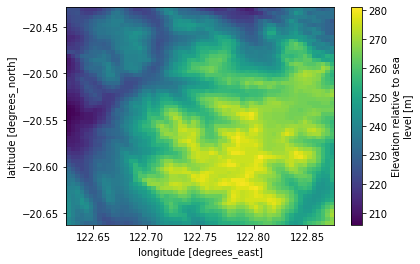

In [20]:
# Plot the GEBCO2023 bathymetry for the test patch
test.plot()

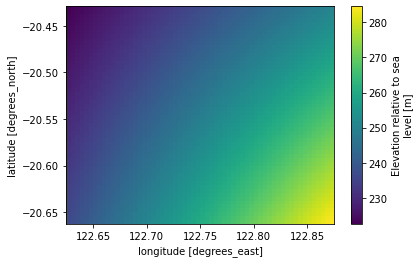

In [21]:
# ...and the fitted surface, H
fit.plot()

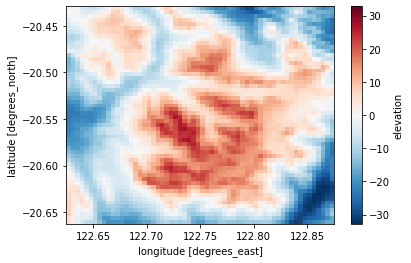

In [22]:
#... and the anomaly, h'=bathymetry-H
(test-fit).plot()

c) Calculate the RMS anomaly and list it

In [23]:

h2_per_bathy_cell=(test-fit)**2
h_rough=np.mean(h2_per_bathy_cell)**0.5
h_rough

<xarray.DataArray 'elevation' ()>
array(12.04722583)

In [9]:
# Use the "bottom_level" variable to produce a land(0)/ocean(1) mask for T-points

botlev=ds_domcfg_GS1p2_full.bottom_level[0,:,:]

mask=xr.where(botlev==0,0,1)

NEMOmask=botlev.copy(data=mask)

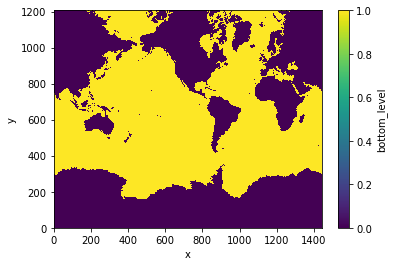

In [10]:
# Plot it to check
NEMOmask.plot()

In [14]:
# What shape is it?  Ah, yes, it includes the 2-point halo.  We really only need [0:1205,0:1440].
NEMOmask.shape

(1207, 1442)

# Then repeat the method over all the NEMO (i,j) gridcells that are ocean....

d) repeat for all the NEMO ocean cells.  Could be computationally optimised?  Inner function calls seemed to pose a challenge for further optimisation, e.g. with Dask.


# **Vectorise in xarray**

In [ ]:
#Define the lat-lon bounds of each NEMO grid cell, using the u- and v-points.
#Strip the halo.

nhalo=2

latmin=Ngphiv[0,0:-nhalo,0:-nhalo].shift(y=1)
latmax=Ngphiv[0,0:-nhalo,0:-nhalo]
lonmin=Nglamu[0,0:-nhalo,0:-nhalo].roll(x=1) #this preserves the cyclic boundary condition
lonmax=Nglamu[0,0:-nhalo,0:-nhalo]


dlon=np.mod(lonmax-lonmin+360,360)*NEMOmask[0:-nhalo,0:-nhalo] #masked longitude increment

dlat=(latmax-latmin)*NEMOmask[0:-nhalo,0:-nhalo] #same for latitude

#Replace lonmax and latmax by lonmin+dlon and latmin+dlat to ensure ranges are controlled
# in terms of having a non-negative-definite increment for each cell.  Also mask all and remove halo.

lonmin=lonmin*NEMOmask[0:-nhalo,0:-nhalo]
lonmax=lonmin+dlon

latmin=latmin*NEMOmask[0:-nhalo,0:-nhalo]
latmax=latmin+dlat

#total number of i, j cells in NEMO grid, excluding halo, over which we will iterate.

imax=lonmin.shape[1]
jmax=lonmin.shape[0]  #as NEMO array is in j,i order

#Initialise
h_rough=np.zeros([jmax+nhalo,imax+nhalo])
#lazily define h as an xarray DataArray by copying an existing one and replacing its data
h=ds_domcfg_GS1p2_full.nav_lon.copy(deep=True,data=h_rough) #choose any variable name with the same shape (here, 'nav_lon') - to be renamed later
h.rename("h") #this renames the nav_lon attribute as h


    
#Loop over NEMO i,j cells
for i in np.arange(0,imax): #excludes the outer 2 halo cells
    for j in np.arange(0,jmax): #excludes the outer 2 halo cells
        #Test whether NEMO gridcell is land or ocean, based on NEMOmask
        testfit=[]
        fit=[]
        patch=[]
        if (NEMOmask[j,i] > 0):
            # Need to add 1 to the i,j indices above to avoid indexing from zero and that if i=0, then i-1 leads to a -ve index problem
            
            #patch=bathy_GEBCO.where( (bathy_GEBCO.lat>=latmin[j,i]) & (bathy_GEBCO.lat<latmax[j,i]) & (bathy_GEBCO.lon>=lonmin[j,i]) & (bathy_GEBCO.lon<lonmax[j,i]))
            patch=bathy_GEBCO.sel(lat=slice(latmin[j,i],latmax[j,i]),lon=slice(lonmin[j,i],lonmax[j,i]))
            
            iimax=patch.shape[0]
            jjmax=patch.shape[1]
            
            if((iimax>1) & (jjmax>1) ) :  #make sure not to attempt to fit to an empty set, a point or a line
                xs = np.linspace(0, iimax-1, iimax)
                ys = np.linspace(0, jjmax-1, jjmax)
                gridx, gridy = np.meshgrid(xs, ys)
                
                # Minimise using least-squares the difference between the fitted function and the patch data
                def fun(theta):
                    return (hyperbolicparaboloid(theta, iimax, jjmax, gridx, gridy).T - patch.values).flatten()                                                
                a = 0.0; b = 0.0; c=0.0; d=0.0 
                theta0=[a,b,c,d]

                
                def fitpardask(fun,theta0):
                    return least_squares(fun,theta0)

                    
                fitpar=fitpardask(fun,theta0)
                testfit=(hyperbolicparaboloid(fitpar.x, iimax, jjmax, gridx, gridy)).T
                # Make a copy of the xarray DataArray matching the attrs of the patch then replace its data with the fitted function
                fit=patch.copy(deep=True, data=testfit)
                h2_per_bathy_cell=(patch-fit)**2 # anomaly-squared
                h[j,i]=np.mean(h2_per_bathy_cell)**0.5
            else:
                h[j,i]=0.0

            # print a measure of progress through the computation    
            if ((np.mod(i,5) == 1) & (np.mod(j,10)==1)):
                print(i,' out of ', imax, ' and ',j,' out of ',jmax)
                
# Save the roughness parameter h to a netCDF file...

h.to_netcdf("/home/users/cwilso01/projects/senemo/data/interim/h_rough_GEBCO2023_domcfg_GS1p2_full.nc")
print("h file written")